In [1]:
%load_ext autoreload
%autoreload 2

import os
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt

import params
from utils import *
from matplotlib.gridspec import GridSpec
import math
from scipy.io import loadmat

# For clustering
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
import scipy as sc
from sklearn.decomposition import SparsePCA

## Cell 1: Load triggers and spikes + select chirp type !!!!

In [2]:
"""
    Variables
    
    DO NOT CHANGE VALUES HERE UNLESS DEBUG/SPECIFIC USE
    
    All the variables used in this part of the cell should always refere to your 'params.py' file
    unless you want to manually change them only for this run (i.e. debugging). 
    You may have to add those variable into the function you want to adapt as only the minimal 
    amount of var are currently given to functions as inputs.
"""

#Experiment name
exp = params.exp

#choose the chirp recording
recording_names = params.recording_names

#Analysis output directory
output_directory=params.output_directory

#Trigger directory
triggers_directory= params.triggers_directory

#Sampling rate of the mea
fs = params.fs  

"""
    Input
"""

#If False: new chirp at 50Hz, if True: old 2p room chirp   !!!!!!!!!
old=False

print(*['{} : {}'.format(i,recording_name) for i, recording_name in enumerate(recording_names)], sep="\n")
recording_number = int(input("\nSelect chirp recording : "))
rec = recording_names[recording_number]
print(f"\nSelected recording : {rec} \n")

CT_directory = os.path.normpath(os.path.join(output_directory,r'CellTyping_Analysis_rec_{}'.format(recording_number)))
if not os.path.isdir(CT_directory): os.makedirs(CT_directory)

check_directory = find_Analysis_Directory(dir_type="Checkerboard")

"""
    Processing
"""

#load triggers
trig_data = load_obj(os.path.normpath(os.path.join(triggers_directory,'{}_{}_triggers.pkl'.format(exp,rec))))
stim_onsets = trig_data['indices']/fs

spike_trains=load_obj(os.path.join(output_directory, r'{}_fullexp_neurons_data.pkl'.format(exp)))

cells=list(spike_trains.keys())
spike_times=[]
for cell in cells:
    spike_times.append(spike_trains[cell][rec])
    
print('Total : {} neurons loaded \n\nClusters id :\n{}\n'.format(len(spike_trains.keys()),cells))


0 : 00_Checkerboard_30ND50%_20pix30checks_30Hz
1 : 01_Checkerboard_30ND50%_16pix40checks_30Hz
2 : 02_DG_30ND50%_2sT_50Hz
3 : 03_Chirp_20reps_30ND50%_50Hz
4 : 04_Flicker_BeforeDrugs_30ND50%_1Hz
5 : 05_VDH_Synchro+MultiSpots(bright)_N8_Z(-35)_30ND50%_40Hz
6 : 06_VDH_Synchro_N10_Z(-35)_30ND50%_40Hz
7 : 07_Flicker_LAP4+ACET_t+10_30ND50%_1Hz
8 : 08_HoloStim1_LAP4+ACET_N8_Z(-35)
9 : 09_HoloStim1_LAP4+ACET_N15_Z(-30)
10 : 10_OptoStim1_LAP4+ACET_15ND50%_1Hz
11 : 11_OptoStim1_LAP4+ACET_5ND50%_1Hz
12 : 12_HoloStim2_GRF_t30_N15_Z(-30)
13 : 13_OptoStim2_GRF_t35_15ND50%_1Hz
14 : 14_OptoStim2_GRF_t40_5ND50%_1Hz
15 : 15_HoloStim3_SR95531_t30_N15_Z(-30)
16 : 16_OptoStim3_SR95531_t35_15ND50%_1Hz
17 : 17_OptoStim3_SR95531_t40_5ND50%_1Hz
18 : 18_HoloStim3_18BG_t5_N15_Z(-30)
19 : 19_OptoStim3_18BG_t10_15ND50%_1Hz
20 : 20_OptoStim3_18BG_t15_5ND50%_1Hz
21 : 21_HoloStim3_18BG_t20_N15_Z(-30)

Select chirp recording : 3

Selected recording : 03_Chirp_20reps_30ND50%_50Hz 

Total : 276 neurons loaded 

Clusters 

## Cell 2: Chirp rasters

In [3]:
"""
    Input
"""

#Number of bins to make psth
n_bins=800    #CHANGE HERE THE NUMBER OF BINS IF NECESSARY

#Number of bins for noise correlation
n_bins_small=16000  # 16000 for 2ms bins, 32000 for 1ms bins with new chirp (32s)
"""
    Processing
"""

print("Extracting cells responses to Chirp stimulus\n")

if old: 
    nb_repetitions = 30
    n_bins=625      #Change here for old chirp n_bins
    rep_lenght=25
else: 
    nb_repetitions = 20 
    rep_lenght=32
time_bin= rep_lenght/n_bins #in seconds

cell_data={}
for idx,cell_nb in tqdm(enumerate(cells[:]), desc="Extraction"):
    if not cell_nb in cell_data.keys(): cell_data[cell_nb]={}
    
    #Get spike_times
    euler_sptimes = spike_times[idx]

    aligned_triggers = stim_onsets  #(in seconds)
    
    # Flashes: Get the repeated sequence times for the specified position
    repeated_sequences_times = []
    for i in range(0,nb_repetitions):
        if old: times = aligned_triggers[i*999:999*(i+1)]
        else: times = aligned_triggers[i*1600+151:151+1600*(i+1)]
        repeated_sequences_times += [[times[0], times[-1]]]

    # Build the spike trains corresponding to stimulus repetitions
    spike_trains = []
    for i in range(len(repeated_sequences_times)):
        spike_train = restrict_array(euler_sptimes, repeated_sequences_times[i][0], repeated_sequences_times[i][1])
        spike_trains += [spike_train]

    # Align the spike trains
    for i in range(len(spike_trains)):
        spike_trains[i] = spike_trains[i] - repeated_sequences_times[i][0]
        
    # Compute psth
    binned_spikes = np.empty((nb_repetitions,n_bins))   #40 ms time bin
    spike_counts_small_bin = np.empty((nb_repetitions,n_bins_small))   #2 ms time bin

    for i in range(nb_repetitions):
        binned_spikes[i,:] = np.histogram(spike_trains[i], bins=n_bins, range=(0,rep_lenght))[0]
        spike_counts_small_bin[i,:] = np.histogram(spike_trains[i], bins=n_bins_small, range=(0,rep_lenght))[0]
    

    psth = np.sum(binned_spikes, axis=0)
    mean_spikes_count = np.sum(spike_counts_small_bin, axis=0)/ nb_repetitions

    # Transform spike count in firing rate 
    binned_spikes = binned_spikes 
    cell_data[cell_nb]["spike_times"] = spike_times
    cell_data[cell_nb]["repeated_sequences_times"] = repeated_sequences_times
    cell_data[cell_nb]["spike_trains"] = spike_trains
    cell_data[cell_nb]["psth"] = psth/time_bin
    
    cell_data[cell_nb]["mean_spikes_count_small_bin"] = mean_spikes_count 
    cell_data[cell_nb]["spikes_counts_small_bin"] = spike_counts_small_bin
    cell_data[cell_nb]["noise_small_bin"] = np.subtract(spike_counts_small_bin, mean_spikes_count)
    cell_data[cell_nb]["noise_large_bin"] = np.subtract(binned_spikes, psth/rep_lenght)



Extracting cells responses to Chirp stimulus



Extraction: 0it [00:00, ?it/s]

## Cell 3: Plot Chirp rasters

With addaed spatial STA in order to be able to use this plot alone to do cell selection for clustering

#### <center><i>REQUIRES CELL 2 RUN AND CHECKERBOARD ANALYSIS</center>

In [4]:
# Plot the rasters

"""
    Input
"""
fig_directory = os.path.normpath(os.path.join(CT_directory,r'Chirp_rasters+STA'))
if not os.path.isdir(fig_directory): os.makedirs(fig_directory)

sta_results=np.load(os.path.join(check_directory,'sta_data_3D_fitted.pkl'),allow_pickle=True)    


if old:
    vec_path = os.path.join('./ressources', r"EulerStim180530.vec")
    euler_vec = -np.genfromtxt(vec_path)
    rep_lenght = 25
    n_bins = 625
    n_reps = 30
    
else:    
    vec_path = os.path.join('./ressources', r"Euler_50Hz_20reps_1024x768pix.vec")
    euler_vec = np.genfromtxt(vec_path) 
    rep_lenght = 32
    n_bins = 800
    n_reps = 20

    
    
"""
    Processing
"""

print(f"Saving Chirp raster plots in : {fig_directory} \n")

time_bin = rep_lenght/n_bins #in seconds
for cell_nb in tqdm(cells[:]):

    fig = plt.figure(figsize=(19,6))
    gs = GridSpec(8, 19, left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.4, hspace=0, figure=fig)
#     fig=plt.figure(figsize=(16,6))

    #plot Chirp stimulus
    ax=fig.add_subplot(gs[0:2, :-3])
    if old:ax.plot(np.linspace(0,rep_lenght,999),euler_vec[1:1000,1], color='k')
    else: ax.plot(np.linspace(0,rep_lenght,1600),euler_vec[151:1751,1], color='k')
    ax.set_ylabel('Chirp Stimulus')
    ax.set_yticks([])
    ax.set_title('Cluster {}'.format(cell_nb))
    ax.set_xlim([0,rep_lenght])

    #plot chirp raster
    ax=fig.add_subplot(gs[2:5, :-3])
    ax.eventplot(cell_data[cell_nb]["spike_trains"],color='k',lw=1,linelengths=1)
    ax.set_ylabel('#Trial')
    ax.set_xlim([0,rep_lenght])
    
    #plot chirp psth
    ax=fig.add_subplot(gs[5:, :-3])
    ax.step(np.linspace(0,rep_lenght,n_bins),cell_data[cell_nb]["psth"])
    ax.set_ylabel('Firing rate Hz \n ({} ms time bin)'.format(int(time_bin*1000)))
    ax.set_xlabel("Time (s)")
    ax.set_xlim([0,rep_lenght])
    
    #plot spatial STA
    ax = fig.add_subplot(gs[0:3, -3:])
    ax.set_title("STA",fontsize=12 )
    spatial = sta_results[cell_nb]['center_analyse']['Spatial']
    spatial = spatial**2*np.sign(spatial)
    cmap='RdBu_r'
    image = ax.imshow(spatial, cmap=cmap,interpolation='gaussian')
    abs_max = 0.5*max(np.max(spatial), abs(np.min(spatial)))
    image.set_clim(-abs_max,abs_max)
    ax.set_xticks([])
    ax.set_yticks([])
    
    fsave = os.path.join(fig_directory, '{}_Chirp_raster+STA'.format(cell_nb)) 
    fig.savefig(fsave+'.png',format='png',dpi=90)
    plt.close(fig)
    
print('--- Cell Done ---')


Saving Chirp raster plots in : /home/guiglaz/Documents/Pipeline_Git_Repo/Analysis/CellTyping_Analysis_rec_3/Chirp_rasters+STA 



  0%|          | 0/276 [00:00<?, ?it/s]

--- Cell Done ---


## Cell 4: Select the cells suited for clustering and save them
Those that have a nice response to the chirp and a well defined STA

In [5]:
"""
    Input
"""

# Manually input here the cells ids to use for the clustering. 
#If empty, checks if selection has already been done, otherwise, starts selection
# Based on STA
good_sta_cells = []# Based on STA
good_chirp_cells = []# Based on chirp

#Path to the file saving the cells to use for clustering
all_selected_cells_file = os.path.normpath(os.path.join(CT_directory, '{}_selected_cells_for_clustering.pkl'.format(exp)))

if os.path.isfile(all_selected_cells_file):
    print(f"Loading previous selection from  : {all_selected_cells_file}")
    all_selected_cells = load_obj(all_selected_cells_file)
    selected_cells = all_selected_cells["selected_cells"]
    selected_cells_sta = all_selected_cells["selected_cells_sta"]
    selected_cells_chirp = all_selected_cells["selected_cells_chirp"]
else:
    selected_cells = []
    selected_cells_sta = []
    selected_cells_chirp = []
    
    
"""
    Processing
""" 

if good_sta_cells:
    selected_cells_sta = good_sta_cells
if good_chirp_cells:
    selected_cells_chirp = good_chirp_cells

selected_cells, selected_cells_sta, selected_cells_chirp = cell_selection_for_clustering(cells, CT_directory_path = CT_directory,selected_cells_sta = selected_cells_sta, selected_cells_chirp = selected_cells_chirp )

print("Selected {} cells.".format(len(selected_cells)))

#and save the selected list
fsave = os.path.join(CT_directory, '{}_selected_cells_for_clustering'.format(exp) )  
save_obj({"selected_cells": selected_cells, "selected_cells_sta":selected_cells_sta, "selected_cells_chirp":selected_cells_chirp},fsave)

Loading previous selection from  : /home/guiglaz/Documents/Pipeline_Git_Repo/Analysis/CellTyping_Analysis_rec_3/Pipeline_DEV_selected_cells_for_clustering.pkl
Selecting via STA ...
List of selected cells using sta :  [519, 1035, 1038, 1046, 1049, 1051, 544, 1057, 35, 36, 1062, 1064, 48, 49, 50, 1072, 1073, 55, 1087, 578, 580, 1092, 1095, 1100, 78, 1104, 1106, 83, 595, 1114, 93, 1122, 1123, 1129, 618, 622, 110, 624, 111, 112, 1135, 116, 1136, 1141, 1142, 1145, 1147, 1148, 1150, 1151, 1152, 1156, 647, 1161, 1163, 652, 1168, 1171, 662, 153, 1179, 668, 1182, 1187, 676, 167, 168, 173, 1197, 1199, 1203, 696, 698, 702, 1215, 193, 1222, 1224, 1225, 714, 715, 1226, 1228, 1230, 719, 1232, 1235, 214, 1242, 221, 1245, 1246, 736, 1247, 227, 229, 1256, 1259, 748, 1264, 1267, 246, 247, 1274, 1278, 1279, 262, 1289, 268, 1292, 783, 1303, 793, 282, 1308, 799, 1315, 1317, 819, 1333, 1336, 1343, 834, 1350, 1351, 843, 1356, 846, 1358, 336, 1359, 1361, 1362, 852, 349, 350, 351, 871, 366, 882, 887, 377, 890,

#### Modify manually your selection

In [6]:
#manually add or remove cell numbers if you failed
selected_cells_sta_to_add = []
selected_cells_sta_to_remove = []

selected_cells_chirp_to_add = []
selected_cells_chirp_to_remove = []

remove_any_way = [864,950, 998,488,1357,1239, 674, 1190, 674, 75, 10, 287,617,154,77,1157,354,90,
                    225, 117, 263, 556, 348,496,186, 1162, 1268, 943, 688, 608, 258, 899, 1306, 999, 988]

selected_cells_sta = list(set([idx for idx in selected_cells_chirp+selected_cells_chirp_to_add if idx not in selected_cells_chirp_to_remove+remove_any_way]))
selected_cells_sta = list(set([idx for idx in selected_cells_sta  +selected_cells_sta_to_add   if idx not in selected_cells_sta_to_remove  +remove_any_way]))

selected_cells, selected_cells_sta, selected_cells_chirp = cell_selection_for_clustering(cells, CT_directory_path=CT_directory, selected_cells_sta = list(set(selected_cells_sta)), selected_cells_chirp = list(set(selected_cells_chirp)) )

fsave = os.path.join(CT_directory, '{}_selected_cells_for_clustering'.format(exp) )  
save_obj({"selected_cells": selected_cells, "selected_cells_sta":selected_cells_sta, "selected_cells_chirp":selected_cells_chirp},fsave)

Selecting via STA ...
List of selected cells using sta :  [519, 1035, 1038, 1046, 1049, 1051, 544, 1057, 35, 36, 1062, 1064, 48, 49, 50, 1072, 1073, 55, 1087, 578, 580, 1092, 1095, 1100, 78, 1104, 1106, 83, 595, 1114, 93, 1122, 1123, 1129, 618, 622, 110, 624, 111, 112, 1135, 116, 1136, 1141, 1142, 1145, 1147, 1148, 1150, 1151, 1152, 1156, 647, 1161, 1163, 652, 1168, 1171, 662, 153, 1179, 668, 1182, 1187, 676, 167, 168, 173, 1197, 1199, 1203, 696, 698, 702, 1215, 193, 1222, 1224, 1225, 714, 715, 1226, 1228, 1230, 719, 1232, 1235, 214, 1242, 221, 1245, 1246, 736, 1247, 227, 229, 1256, 1259, 748, 1264, 1267, 246, 247, 1274, 1278, 1279, 262, 1289, 268, 1292, 783, 1303, 793, 282, 1308, 799, 1315, 1317, 819, 1333, 1336, 1343, 834, 1350, 1351, 843, 1356, 846, 1358, 336, 1359, 1361, 1362, 852, 349, 350, 351, 871, 366, 882, 887, 377, 890, 387, 900, 906, 918, 926, 422, 423, 934, 938, 939, 940, 946, 444, 957, 958, 962, 966, 457, 465, 466, 980, 989, 478, 480, 993, 482, 996, 997, 486, 1004, 493, 49

## Cell 5: Cell typing: Agglomerative Clustering

#### <center><i>REQUIRES CELL 2, CELL 4 AND CELL 5 RUN </center>

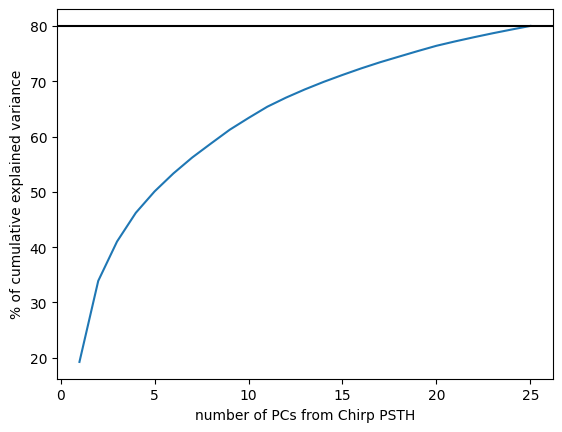

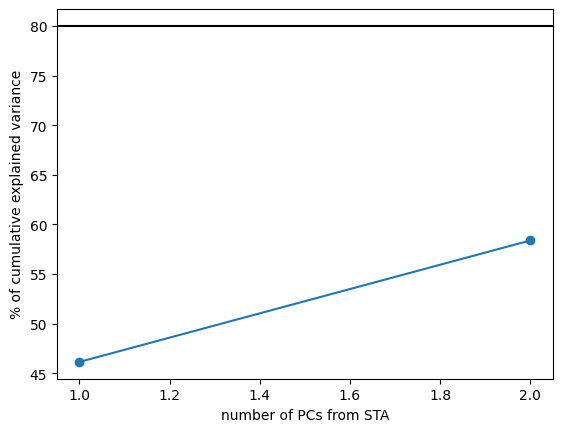

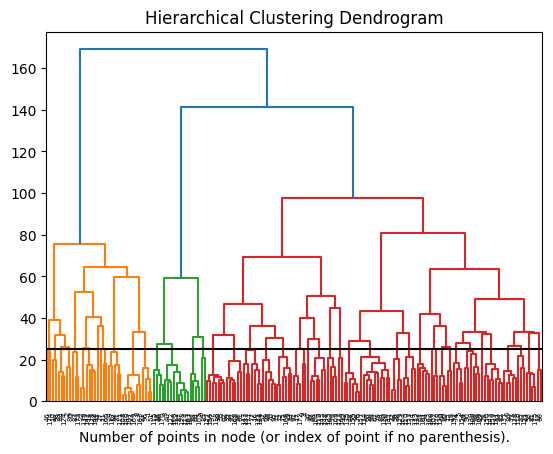

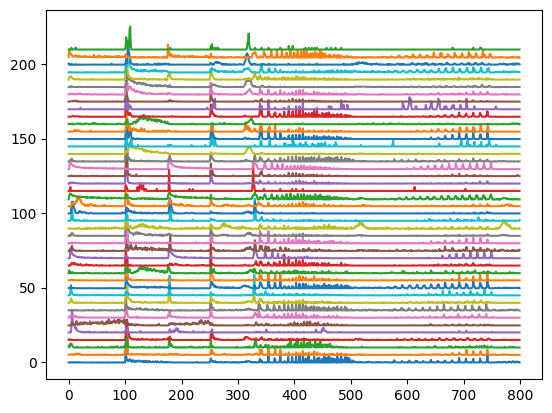

Number of clusters:  43


In [7]:
"""
    Input
"""

sta_results=np.load(os.path.join(check_directory,'sta_data_3D_fitted.pkl'),allow_pickle=True)


# change dist_thres to adapt the cut of the dendrogram and select the number of clusters
#####################################################################
dist_thres = 25#13
#####################################################################

# Select number of PCs to keep so to explain ~80% of the variance
#####################################################################
n_components_psth = 25  #13#16
#####################################################################

#####################################################################
n_components_sta_tc = 2
#####################################################################

sparse=False



"""
    Processing
"""

n_cells = len(selected_cells)
#-----------------------------------
#-----------------------------------
# Get Euler PCA
n_rep = 20 # nb of repeats
nt = 32 # total length
dt = 0.04 # bin size in seconds
time_bins = np.arange(0,nt+dt,dt)

#Bining 
spikes = np.zeros((n_cells, int(nt/dt), n_rep))
for cell_index in range(len(selected_cells)):
    cell_id = selected_cells[cell_index]
    spike_cell = cell_data[cell_id]["spike_trains"]
    for rep in range(n_rep):
        temp=np.histogram(spike_cell[rep], bins=time_bins)
        spikes[cell_index,:,rep] = temp[0]

#-------------------------
# Pre process the PSTH
psth = np.mean(spikes, 2)
psth_z = sc.stats.zscore(psth, 1)

if sparse:
    pca_transformer = SparsePCA(n_components_psth, random_state=0).fit(psth_z)
else:
    pca_transformer = PCA(n_components_psth).fit(psth_z)
psth_pca = pca_transformer.transform(psth_z)


# -----------------------------------
# Get checkerboard STA PCA
STA_time_course = np.zeros((n_cells,21))  #21 data points for these STAs
for cell_index in range(len(selected_cells)):
    cell_id = selected_cells[cell_index]
    TempSTA_cell = sta_results[selected_cells[cell_index]]['center_analyse']['Temporal'][-21:]
    STA_time_course[cell_index] = TempSTA_cell

#---------------------------
# Pre process the STA
sta_tc = sc.stats.zscore(STA_time_course[:,:], 1)

if n_components_sta_tc>0:
    pca_transformer2 = PCA(n_components_sta_tc).fit(sta_tc)
    sta_tc_pca = pca_transformer2.transform(sta_tc)


        
#-----------------------------------
cluster_dataset = np.zeros((n_cells, n_components_psth+n_components_sta_tc+1))
cluster_dataset[:,:n_components_psth] = psth_pca
if n_components_sta_tc>0:
    cluster_dataset[:,n_components_psth:n_components_psth+n_components_sta_tc] = sta_tc_pca

ell_size=np.zeros(len(selected_cells))
for cell_index in range(len(selected_cells)):
    cell_id = selected_cells[cell_index]
    width,height = [sta_results[selected_cells[cell_index]]['center_analyse']['EllipseCoor'][3],  sta_results[selected_cells[cell_index]]['center_analyse']['EllipseCoor'][4]]
#     width,height = cell_data[cell_id]["ellipseSigmaXY"]
    ell_size[cell_index] = np.abs(np.pi*width*height)
    
ell_size_temp = -np.ones(n_cells)
temp = ell_size[:]-ell_size[:].min()
ell_size_temp[:] = temp/temp.max()
cluster_dataset[:,-1] = ell_size_temp

#-----------------------------------
# perform agglomerative clustering
model = AgglomerativeClustering(distance_threshold=dist_thres, n_clusters=None)
#model = model.fit(psth_pca)
model = model.fit(cluster_dataset)



"""
    Plotting
"""

# Plot cumlative explained variance
if not sparse:
    #For chirp PCAs
    plt.plot(np.arange(n_components_psth)+1, np.cumsum(pca_transformer.explained_variance_ratio_)*100)
    plt.axhline(y=80, color='k')
    plt.xlabel('number of PCs from Chirp PSTH')
    plt.ylabel('% of cumulative explained variance')
    plt.show()

    if n_components_sta_tc>0:
        #For STA PCAs
        plt.plot(np.arange(n_components_sta_tc)+1, np.cumsum(pca_transformer2.explained_variance_ratio_)*100,'o-')
        plt.axhline(y=80, color='k')
        plt.xlabel('number of PCs from STA')
        plt.ylabel('% of cumulative explained variance')
        plt.show()


# plot the dendrogram
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(model, truncate_mode='level', p=0)
plt.axhline(dist_thres, color='k')
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

# plot the cluster centroids
n_clusts = len(np.unique(model.labels_))
plt.figure()
for iclust in range(n_clusts):
    idx_cluster = np.where(model.labels_==iclust)[0]
    plt.plot(np.mean(psth_z[idx_cluster,:], 0) + iclust * 5)
plt.show() 
    
print('Number of clusters: ',len(np.unique(model.labels_)))

# # plot the psths of all cells in one cluster
# for icluster in range(len(np.unique(model.labels_))):
#     # icluster = 0
#     idx_cluster = np.where(model.labels_==icluster)[0]
#     print(f'cluster size : {len(idx_cluster)}')
#     plt.figure()
#     plt.plot(psth_z[idx_cluster,:].transpose())
#     plt.show()

## Cell 6: Save each cell's cluster number in the chirp response dictionary

In [9]:
# Save the cluster of each cell
for cell_index in range(len(selected_cells)):
    cell_nb = selected_cells[cell_index]
    cell_data[cell_nb]["type"] = model.labels_[cell_index]
for cell in cells:
    if cell not in selected_cells:
        cell_data[cell]["type"] = 'Not assigned'

## Cell 7: Compute cross-correlation inside clusters

In [11]:
"""
    Input
"""

#Number of bins to make psth
n_bins=16000    #CHANGE HERE THE NUMBER OF BINS IF NECESSARY
max_shift = 50
"""
    Processing
"""

if old: 
    nb_repetitions = 30
    n_bins=625      #Change here for old chirp n_bins
    rep_lenght=25
else: 
    nb_repetitions = 20 
    rep_lenght=32
time_bin= rep_lenght/n_bins #in seconds

# #--------------------
# #Compute noise spike counts
# for idx,cell_nb in tqdm(enumerate(cell_data.keys()), desc="Small time scall bining"):
#     # Compute psth
#     spike_counts_small_bin = np.empty((nb_repetitions,n_bins))   #2 ms time bin
#     for i in range(nb_repetitions):
#         spike_counts_small_bin[i,:] = np.histogram(cell_data[cell_nb]["spike_trains_small"][i], bins=n_bins, range=(0,rep_lenght))[0]
#     # Take the mean spike counts over all repetitions 
#     mean_spikes_count = np.sum(spike_counts_small_bin, axis=0)/ nb_repetitions

#     cell_data[cell_nb]["mean_spikes_count_small_bin"] = mean_spikes_count 
#     cell_data[cell_nb]["spikes_counts_small_bin"] = spike_counts_small_bin
#     cell_data[cell_nb]["noise_small_bin"] = np.subtract(spike_counts_small_bin, mean_spikes_count)
    
    
#--------------------
#Compute correlation inside a cell type
for icluster in tqdm(range(len(list(set([cell_data[cell]["type"] for cell in cell_data.keys() if cell_data[cell]["type"] != 'Not assigned']))))[:], desc="Computing noise correlations within cell types"):
    idx_cluster = sorted(list(np.where(np.asarray([cell_data[cell]["type"] for cell in cell_data.keys() if cell_data[cell]["type"] != 'Not assigned'])==icluster)[0]))
    for index in idx_cluster:
        cell = selected_cells[index]
        cell1 = np.sum(cell_data[cell]["noise_small_bin"],axis=0)/nb_repetitions
        corrs =[]
        dist=[]
        max_corr =[]
        for index_corr in [idx for idx in idx_cluster if idx!=index]:
            cell_corr = selected_cells[index_corr]
            cell2 = np.sum(cell_data[cell_corr]["noise_small_bin"],axis=0)/nb_repetitions
            dist.append(np.linalg.norm(np.asarray(sta_results[cell_corr]["center_analyse"]['EllipseCoor'][1:3])-np.asarray(sta_results[cell]["center_analyse"]['EllipseCoor'][1:3])))  #np.asarray is needed here due to a former bug in ellipses not fitted coordinates format
            corrs.append(correlate_PersonPM(cell2,cell1, max_shift=max_shift))
            max_corr.append(np.corrcoef(np.sum(cell_data[cell]["noise_large_bin"],axis=0)/nb_repetitions,np.sum(cell_data[cell_corr]["noise_large_bin"],axis=0)/nb_repetitions)[0,1]
)
        cell_data[cell]["corrs"] = corrs
        cell_data[cell]["mean_corr"] = np.mean(np.asarray(corrs), axis=0)
        cell_data[cell]["distances"] = dist
        cell_data[cell]["max_corr"] =  max_corr
        
        

Computing noise correlations within cell types:   0%|          | 0/43 [00:00<?, ?it/s]

/home/guiglaz/anaconda3/envs/spk/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/guiglaz/anaconda3/envs/spk/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [70]:
cell_data[i].keys()

dict_keys(['spike_times', 'repeated_sequences_times', 'spike_trains', 'psth', 'mean_spikes_count', 'spike_counts', 'noise', 'type'])

In [76]:
ma = 0
mi = 0
max_rep = 300
idx = 0
for i in cell_data.keys():
    for j in range(20):
        try:
            a = cell_data[i]["corrs"]
        except:
            pass
        if len(a) == 0:
            continue
        if np.nanmin(a)<mi:
            mi = np.nanmin(a)
        if np.nanmax(a)>ma:
            ma=np.nanmax(a)
#         plt.figure()
#         plt.plot(a)
    if idx>=max_rep:
        break
    else:
        idx+=1
print(ma)


0.2644746797032754


for icluster in tqdm(range(len(list(set([cell_data[cell]["type"] for cell in cell_data.keys() if cell_data[cell]["type"] != 'Not assigned']))))[:]):
    idx_cluster = sorted(list(np.where(np.asarray([cell_data[cell]["type"] for cell in cell_data.keys() if cell_data[cell]["type"] != 'Not assigned'])==icluster)[0]))
    for index in idx_cluster:
        cell = selected_cells[index]
        cell1 = cell_data[cell]["psth"]
        corrs =[]
        dist=[]
        for index_corr in [idx for idx in idx_cluster if idx!=index]:
            cell_corr = selected_cells[index_corr]
            cell2 = cell_data[cell_corr]["psth"]
            corrs.append(correlate_PersonPM(cell2,cell1))
            dist.append(np.linalg.norm(np.asarray(sta_results[cell_corr]["center_analyse"]['EllipseCoor'][1:3])-np.asarray(sta_results[cell]["center_analyse"]['EllipseCoor'][1:3])))  #np.asarray is needed here due to a former bug in ellipses not fitted coordinates format
        cell_data[cell]["corrs"] = corrs
        cell_data[cell]["mean_corr"] = np.mean(np.asarray(corrs), axis=0)
        cell_data[cell]["distances"] = dist

## Cell 8: Create a summary figure for each cluster type

#### <center><i>REQUIRES CELL 6 RUN </center>

In [ ]:
    ax = fig.add_subplot(gs[2:5, 1:4],polar=True)

    theta = np.linspace(0, 2 * np.pi, 9)
    # Arrange the grid into number of sales equal parts in degrees
    lines, labels = plt.thetagrids(range(0, 360, int(360/8)),np.arange(0,360,45))

    # Plot actual sales graph
    ax.plot(theta, DG_set[cell]['Tuning'])
    ax.fill(theta, DG_set[cell]['Tuning'], 'b', alpha=0.1)

    ax.plot([DG_set[cell]['atune'],DG_set[cell]['atune']],[0,R],'b-')
    ax.plot([DG_set[cell]['atune']],[DG_set[cell]['Rtune']],'bo')

    ax.set_yticks([0,0.25,0.5,0.75,1])
    ax.set_yticklabels([])
    ax.set_ylim([0,1])

In [16]:
DG_set = load_obj(os.path.join(find_Analysis_Directory(dir_type="DG"),f'DG_data_exp{exp}'))
DG_set[10].keys()

dict_keys(['IDX', 'Tuning', 'atune', 'Rtune', 'rasters', 'counts', 'maxcount', 'bins'])

In [28]:
""" 
    Input
"""
#Name of the experiment
exp=params.exp
DG_set = load_obj(os.path.join(find_Analysis_Directory(dir_type="DG"),f'DG_data_exp{exp}'))

fig_directory = os.path.normpath(os.path.join(CT_directory,r'Cell_typing'))
if not os.path.isdir(fig_directory): os.makedirs(fig_directory)

if old:
    vec_path = os.path.join('./ressources', r"EulerStim180530.vec")
    euler_vec = -np.genfromtxt(vec_path)  
else:    
    vec_path = os.path.join('./ressources', r"Euler_50Hz_20reps_1024x768pix.vec")
    euler_vec = np.genfromtxt(vec_path) 


    
"""
    Plotting
"""

for icluster in tqdm(range(len(list(set([cell_data[cell]["type"] for cell in cell_data.keys() if cell_data[cell]["type"] != 'Not assigned']))))[:]):
    idx_cluster = sorted(list(np.where(np.asarray([cell_data[cell]["type"] for cell in cell_data.keys() if cell_data[cell]["type"] != 'Not assigned'])==icluster)[0]))
    print('Number of cells in cluster {}: {}'.format(icluster,len(idx_cluster)))

    gs = GridSpec(len(idx_cluster)+2, 10)
    
    if len(idx_cluster)<7:
        yspan = 2
    else:
        yspan=-2
    fig=plt.figure(figsize=(22,(len(idx_cluster)+yspan)*1.75))
    plt.suptitle("Cell group {}.\n {} cells.".format(icluster, len(idx_cluster)))

    #-------------------------------
    # Loop cells in cluster
    line = 2
    STAs=np.zeros(21)
    STAcount=0
    waves=np.zeros(101)
    wavecount=0
    ax0= fig.add_subplot(gs[0:2,1:3])
    ax_dist_corr= fig.add_subplot(gs[0:2,8:])
    
    # Set the color cycle for the axis
#     colors = ['blue', 'lightblue', 'skyblue', 'deepskyblue', 'dodgerblue', 'royalblue', 'steelblue', 'mediumslateblue', 'darkslateblue', 'midnightblue']
#     ax_dist_corr.set_prop_cycle('color', colors)
    cum_dist = []
    cum_corr = []
    for index in sorted(idx_cluster):
        cell_nb = selected_cells[index]
        
        #-----------------
        # Plot temp STA
        ax= fig.add_subplot(gs[line,2])
        
#         ax.set_ylim([-4,4])
        ax.axis("off")
        ax.set_aspect(0.175)
        temporal_sta=sta_results[cell_nb]['center_analyse']['Temporal'][-21:]
        ax.step(np.linspace(-21/30,0,21),temporal_sta,'k',lw=3)
#         ax.set_title('Cluster {}'.format(cell_nb))
        ax.axhline(0,color='k',lw=0.5)
        
        STAs+=temporal_sta
        STAcount+=1
        
        #-----------------
        # Plot temp STA avg
        ax= fig.add_subplot(gs[0,3])
        
        ax.set_title('Temp STA')
        ax.set_ylim([-4,4])
        ax.plot(np.linspace(-21/30,0,21),temporal_sta,lw=0.5)
        ax.axhline(0,color='k',lw=0.5)
        ax.set_xlabel('Time(s)')
        
         #-----------------
        # plot Chirp
        ax= fig.add_subplot(gs[line,4:8])
        
        cell_index=selected_cells.index(cell_nb)
        ax.plot(np.linspace(0,32,800),cell_data[cell_nb]["psth"])
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xticks([])
        plt.locator_params(axis="y", nbins=3)
        
        if cell_data[cell_nb]["corrs"] != []:
            #-----------------
            # plot correlation over distance
            sorted_dists, sorted_max_corr = zip(*sorted(zip(cell_data[cell_nb]["distances"], cell_data[cell_nb]["max_corr"])))
            cum_dist+= list(sorted_dists)
            cum_corr+= list(sorted_max_corr)
            
            ax_dist_corr.scatter(sorted_dists, sorted_max_corr, marker='o', linewidths=1, color='lightblue', alpha=0.5)
            ax_dist_corr.plot(sorted_dists, sorted_max_corr, linestyle='-', linewidth=1, alpha=0.5)
            ax_dist_corr.set_title("Correlations")
            ax_dist_corr.set_zorder(20)
            ax_dist_corr.set_visible(True)
            #-----------------
            # plot correlations

            ax = fig.add_subplot(gs[line,8:])
            plt.plot(np.arange(-int(len(cell_data[cell_nb]["mean_corr"])/2),int(len(cell_data[cell_nb]["mean_corr"])/2)+1,1), cell_data[cell_nb]["mean_corr"], linewidth=1)
            plt.fill_between(np.arange(-int(len(cell_data[cell_nb]["mean_corr"])/2),int(len(cell_data[cell_nb]["mean_corr"])/2)+1,1), np.min(np.asarray(cell_data[cell_nb]["corrs"]),axis=0), np.max(np.asarray(cell_data[cell_nb]["corrs"]),axis=0), alpha=0.35)
            ax.set_xticks([])
#             ax.set_yticks([0,0.5,1])
            
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
        else :
            ax_dist_corr.set_visible(False)
            sorted_dists = []
            sorted_max_corr = []
        
        #-----------------
        # plot Spatial STA
        ax= fig.add_subplot(gs[line,1])
        
        parameters=sta_results[cell_nb]['center_analyse']['EllipseCoor']
        x0=parameters[1]
        y0=parameters[2]
        
        ax = plot_sta(ax, sta_results[cell_nb]['center_analyse']['Spatial'],parameters)
        ax.set_xlim(x0-4,x0+4)
        ax.set_ylim(y0+4,y0-4)
        ax.set_aspect('equal')
        ax.set_xticks([])
        ax.set_yticks([])
        
        gaussian = gaussian2D(sta_results[cell_nb]['center_analyse']['Spatial'].shape,*parameters)
        if parameters[0] != 0:
            ax0.contour(np.abs(gaussian),levels = [0.6*np.max(np.abs(gaussian))], colors='k',linestyles = 'solid', alpha = 0.8)

        ax= fig.add_subplot(gs[line,3])
        ax.annotate('Cluster {}'.format(cell_nb), (0,0.5), (0, 0.5), fontsize=15)

        ax.axis('off')
        
        #----------------
        # plot orientation selectivity
        ax = fig.add_subplot(gs[line, 0],polar=True)
        
        theta = np.linspace(0, 2 * np.pi, 9)
        # Arrange the grid into number of sales equal parts in degrees
        lines, labels = plt.thetagrids(range(0, 360, int(360/8)),np.arange(0,360,45))
        # Plot actual sales graph
        ax.plot(theta, DG_set[cell_nb]['Tuning'])
        ax.fill(theta, DG_set[cell_nb]['Tuning'], 'b', alpha=0.1)
        ax.plot([DG_set[cell_nb]['atune'],DG_set[cell_nb]['atune']],[0,DG_set[cell]['Rtune']],'b-')
        ax.plot([DG_set[cell_nb]['atune']],[DG_set[cell_nb]['Rtune']],'bo')
        ax.set_yticks([0,0.333,0.666, 1])
        ax.set_yticklabels([])
        ax.set_xticklabels([0,'','', 135,'',225,'',''])
        ax.set_ylim([0,1])
    
        
        line+=1
    #-----------------
    # avg STA
    STAs=STAs/STAcount
    ax= fig.add_subplot(gs[0,3])
    ax.plot(np.linspace(-21/30,0,21),STAs,'k',lw=2)
#     ax.set_ylim([-4,4])
    ax.set_aspect(0.175)
    ax.axis("off")

    #-----------------
    #size ellipses
    
    ax0.set_title('Ellipses')
#     ax0.set_xlim(4,20)
#     ax0.set_ylim(20,4)
    ax0.set_aspect('equal')
    ax0.set_xticks([])
    ax0.set_yticks([])
        
    #-----------------
    # mean chirp psth
    ax= fig.add_subplot(gs[0,4:8])
    ax.set_title('Chirp psth')
    
    ax.plot(np.linspace(0,32,800),np.mean(psth_z[idx_cluster,:], 0),'b')
    ax.axis("off")

    #-----------------
    # plot chirp stim
    ax= fig.add_subplot(gs[1,4:8])
    
    ax.plot(np.linspace(0,32,1600),euler_vec[0+151:151+1600,1]*1., color='k')
    ax.set_yticks([])
    ax.set_ylim([-100,350])
    ax.set_xlabel('Time(s)')
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    
    #-----------------
    # plot mean correlation over distance
    
    if cell_data[cell_nb]["corrs"] != []:
        sorted_dists, sorted_max_corr = zip(*sorted(zip(cum_dist,cum_corr)))
    #     n_bin = int(len(sorted_dists)/1)
    #     print(n_bin)
        n_bin=10

        xlim = np.linspace(min(sorted_dists), max(sorted_dists),n_bin+1)
        mean = [np.mean(np.asarray(sorted_max_corr)[np.where(np.logical_and(sorted_dists>=xlim[i] , sorted_dists<=xlim[i+1]))[0]]) for i in range(len(xlim)-1)]
        lmin = [min(np.asarray(sorted_max_corr)[np.where(np.logical_and(sorted_dists>=xlim[i] , sorted_dists<=xlim[i+1]))[0]], default=np.nan) for i in range(len(xlim)-1)]
        lmax = [max(np.asarray(sorted_max_corr)[np.where(np.logical_and(sorted_dists>=xlim[i] , sorted_dists<=xlim[i+1]))[0]], default=np.nan) for i in range(len(xlim)-1)]

        x_pos = np.linspace(min(sorted_dists), max(sorted_dists),n_bin)
        ax_dist_corr.plot(x_pos[np.isfinite(mean)],np.asarray(mean)[np.isfinite(mean)], color='#1f77b4')
#         ax_dist_corr.fill_between(x_pos[np.isfinite(lmin) & np.isfinite(lmax)],np.asarray(lmin)[np.isfinite(lmin) & np.isfinite(lmax)],np.asarray(lmax)[np.isfinite(lmin) & np.isfinite(lmax)], alpha=0.2)
    
    fsave = os.path.join(fig_directory, 'Cluster_{}'.format(icluster))
    fig.savefig(fsave+'.png',format='png',dpi=250)
    plt.close(fig)

    
    

  0%|          | 0/43 [00:00<?, ?it/s]

Number of cells in cluster 0: 5
Number of cells in cluster 1: 7
Number of cells in cluster 2: 3
Number of cells in cluster 3: 6
Number of cells in cluster 4: 2
Number of cells in cluster 5: 3
Number of cells in cluster 6: 5
Number of cells in cluster 7: 4
Number of cells in cluster 8: 3
Number of cells in cluster 9: 5
Number of cells in cluster 10: 6
Number of cells in cluster 11: 6
Number of cells in cluster 12: 2
Number of cells in cluster 13: 4
Number of cells in cluster 14: 4
Number of cells in cluster 15: 2
Number of cells in cluster 16: 5
Number of cells in cluster 17: 4
Number of cells in cluster 18: 2
Number of cells in cluster 19: 3
Number of cells in cluster 20: 2
Number of cells in cluster 21: 2
Number of cells in cluster 22: 4
Number of cells in cluster 23: 1
Number of cells in cluster 24: 11
Number of cells in cluster 25: 7
Number of cells in cluster 26: 7
Number of cells in cluster 27: 4
Number of cells in cluster 28: 9
Number of cells in cluster 29: 1
Number of cells in 

In [30]:
plt.close('all')
import gc
gc.collect()

0

## Cell 9: When satisfied with the clustering, save data

In [16]:
fsave = os.path.join(CT_directory, '{}_cell_typing_data'.format(exp) )  
save_obj(cell_data,fsave)

# fsave = os.path.join(output_directory, 'Exp{}_clustermodel'.format(exp) )  
# save_obj([model,psth_z],fsave)

# ----------------------work in progress-----------------------------------

In [ ]:
def calcium_exp(x):
    a =           0
    b =       1.086 
    c =       1.747 -1.0              ##################### changes here
    val = a+b*np.exp(-c*x)
    return val

def toCalciumLinear(time_sequence, spike_train):
    calcium_filter = calcium_exp(time_sequence);
    
    stitch3 = np.append(spike_train,[spike_train,spike_train])
    
    calcium_trace = np.convolve(stitch3, calcium_filter, 'full')[len(spike_train):len(spike_train)*2];
    calcium_trace = calcium_trace-min(calcium_trace)
    calcium_trace=calcium_trace/max(calcium_trace)
    return calcium_trace

# Matching with Baden et al. clusters

In [ ]:
types_matching_folder= './types_matching'
baden=loadmat(os.path.join( types_matching_folder,'baden_data.mat'))
calcium=loadmat(os.path.join( types_matching_folder,'calcium_conversion.mat'))

#the normalized profile of the chirp stimulus used in Baden et al.  #31988 points
chirp_stim=baden['chirp_stim'][:,0]/max(baden['chirp_stim'][:,0])

#the triggers used in Baden et al. plus two seconds (to match them with our stimulus)  #31988 points
chirp_stim_time = baden['chirp_stim_time'][0,:] +2

# a 249 points array from 0 to 32 seconds. Times of calcium sampling at 8Hz?
baden_time_original = baden['chirp_time'][0,:]

# a (11210, 1) array. I suppose 11210 were the measurements taken and in this array are the labels of the groups
# in which each measurment was clustered
group_idx = baden['group_idx'] 

# the average calcium traces for each measurement. Each measurement has 249 time points.
psth_euler = baden['chirp_avg']

#here I load from a csv the labels of the Baden types
euler_labels_f = open(os.path.join( types_matching_folder, 'Baden Types'))
euler_labels_f = csv.reader(euler_labels_f,delimiter=",");
euler_labels={}    #this contains the 32 labels of the euler cell types
c=0
for row in euler_labels_f:
    if c==0:
        stim_cond_head = row
        c=1
    else:
        euler_labels[c-1]= row
        c+=1
#------------------- 

n_baden_types = len(euler_labels)

#our stimulus. Load it and normalize it
vec_path = './types_matching/Euler_50Hz_20reps_1024x768pix.vec'
euler_vec = np.genfromtxt(vec_path)
euler_vec = euler_vec[151:151+1600,1]/max(euler_vec[151:151+1600,1])

#### Repeat this check for the older chirp version!!!!!!

nb_chirp_bins=cell_data[cells[0]]["psth"].size

plt.figure(figsize = (16,4))
time_stim = np.linspace(0,32,1600+1)[:-1]
time = np.linspace(0,32,nb_chirp_bins+1)[:-1]
# Our chirp
plt.plot(time_stim, euler_vec, label='our chirp')
euler_vec.shape
euler_vec[::5].shape,time.shape
# Baden chirp
plt.plot(chirp_stim_time ,chirp_stim+1.5, label = 'Baden chirp')
chirp_stim_time.shape, chirp_stim.shape
plt.legend(frameon=False)

# Comparison range:
comp_range = [0.1,31.9]         # to avoid prestep effects ### why 0.1 and not 2 ?
delta_range = comp_range[1]-comp_range[0]
time_common = np.linspace(comp_range[0],comp_range[1],int(delta_range/0.05) +2)


In order to make ours and the baden traces match we have to shift Baden's sampling times of two seconds. But then this will create missing sampling times for Baden and so here we take the last two seconds worth of Baden's sampling times and we stitch them at the beginning of the sampling times sequence

In [ ]:
# the two additional seconds at the end of Baden stim that will be stitched in the beginning
baden_time = baden_time_original+2
baden_first = baden_time[-15:]-32 
baden_time = np.append(baden_first,baden_time[:-15])

#we do the same for the calcium traces
Baden_types = []

plt.figure(figsize=(8,16))

for i in np.arange(n_baden_types)+1:
    #here the calcium traces of all the recordings of each type are averaged together
    trace = np.mean(psth_euler[:,(group_idx==i)[:,0]],1)  
    #and here they are all put between 0 and 1
    trace = trace-min(trace)
    trace = trace/max(trace)
    trace = np.append(trace[-15:],trace[:-15])                # I stitch the last 2 s in the beggining so that it is 
                                                              #  the same as my experimental stim
    Baden_types.append(trace)
    plt.plot(baden_time,trace-i)
    plt.text(35,-i,str(i)+'  '+euler_labels[i-1][0])

## Transform the clustering results into calcium traces

In [ ]:
## make it loadable!!

labels = model.labels_
exp_labels = np.sort(np.unique(labels))
psth_z.shape, 'Ncells  - Ndatapoints'

In [ ]:
# Generate experiment type traces
Exp_types = []
fig = plt.figure(figsize=(12,24))
fig.add_subplot(1,2,1)
for i in exp_labels:
    #I repeat to my spiking data the treatment I did for the Euler's calcium traces
    trace = np.mean(psth_z[(labels==i),:],0)
    trace = trace-min(trace)
    trace = trace/max(trace)
    Exp_types.append(trace)
    plt.plot(time,trace+i)
    plt.title('Mean psth')

# Experiment to calcium
Exp_types_Ca = {}
fig.add_subplot(1,2,2)
for i in exp_labels:
    # I transform each cluster's mean psth into a calcium trace
    trace = toCalciumLinear(time,Exp_types[i])
    Exp_types_Ca[i] = trace    #the only difference is that my made-up calcium traces have the dimension of the 
                                #number of bins the PSTHs had while the baden traces have dimension 249
    plt.plot(time,trace+i)
    plt.title('Mean Calcium transform')

# Correlate Groups

In [ ]:
from scipy import interpolate

# Interpolate both calcium traces (Baden and transformed traces) and then calculate them on the same set of times
Baden_common = {}
for i in np.arange(n_baden_types):
    f = interpolate.interp1d(baden_time, Baden_types[i])
    Baden_common[i] = f(time_common)   # use interpolation function returned by `interp1d`

Exp_common={}
for i in exp_labels:
    f = interpolate.interp1d(time, Exp_types_Ca[i])
    Exp_common[i] = f(time_common)   # use interpolation function returned by `interp1d`

#n_matches = 29
corr_table = np.zeros([len(exp_labels),n_baden_types]) 
corr_match = np.zeros([len(exp_labels),n_baden_types])
corr_match_vals = np.zeros([len(exp_labels),n_baden_types])
delta_match = np.zeros([len(exp_labels),n_baden_types+1])

# For each of our generated calcium type we compute the corr coef with each Baden type
for i in exp_labels:
    for j in np.arange(n_baden_types):
        corr_table[i,j] = np.corrcoef(Exp_common[i], Baden_common[j])[0,1]
    # For each calcium type, sort de corr coefs in descending order (max first)
    corr_match[i,:] = np.flip(np.argsort(corr_table[i,:])[-32:]) # sorted indices
    corr_match_vals[i,:] = corr_table[i,:][np.flip([np.argsort(corr_table[i,:])[-32:]])] # sorted corr coef values
    # Select the 10 larger corr coefs and store the difference with the next one
    for j in np.arange(10):
        #each row is one of our clusters and each column is the corr.coeff of that cluster with a Baden one. Decreasing order
        delta_match[i,j] = corr_match_vals[i,j]-corr_match_vals[i,j+1]  

# Manual selection of groups

In [ ]:
my_clusters = range(68)
my_clusters = [0,4,5,8,18,24,32,50,54]

colors = ['orange','r','g','pink','y','gray','k','c','m','darkgray','coral','gold','plum','wheat','navy']
#             0     1   2    3     4    5     6   7   8      9         10      11     12      13     14

baden_cluster=23

for my_clus in my_clusters:

    i=np.where(corr_match[my_clus,:]==baden_cluster)[0][0]
    plt.figure(figsize=(12,2))
    plt.plot(baden_time, Baden_types[baden_cluster],lw=3)
    plt.title('{}, {}'.format(euler_labels[baden_cluster], my_clus))
    
    plt.plot(time, Exp_types_Ca[my_clus],color=colors[my_clus%15])
#     plt.xlabel('match '+colors[n_match%15]+' n ' +str(n_match)+' val '+str(np.round(corr_match_vals[cluster_idx][n_match]*100)) )
#     print('match',str(n_match),' ',j, 'Baden ',i)
#----------------------------------------------------
# manual_selection = corr_match[:,0].astype('int')

# manual_selection=np.zeros()

# manual_selection[5] = corr_match[5,5]
# manual_selection[6] = corr_match[6,14]
# manual_selection[7] = corr_match[7,9]
# manual_selection[9] = corr_match[9,3]
# manual_selection[10] = corr_match[10,21]
# manual_selection[13] = corr_match[13,12]
# manual_selection[14] = corr_match[14,15]
# manual_selection[15] = corr_match[15,15]
# manual_selection[18] = corr_match[18,4]
# manual_selection[19] = corr_match[19,9]
# manual_selection[20] = corr_match[20,4]
# manual_selection[22] = corr_match[22,12]
# manual_selection[25] = corr_match[25,2]
# manual_selection[27] = corr_match[27,10]
# manual_selection[29] = corr_match[29,1]
# manual_selection[32] = corr_match[32,10]

# manual_selection[37] = corr_match[37,25]
# manual_selection[38] = corr_match[38,13]
# manual_selection[41] = corr_match[41,18]
# manual_selection[46] = corr_match[46,1]
# manual_selection[64] = corr_match[64,13]
# manual_selection[66] = corr_match[66,3]
# manual_selection[67] = corr_match[67,21]
# manual_selection[68] = corr_match[68,16]
# manual_selection[69] = corr_match[69,5]
# manual_selection[70] = corr_match[70,1]
# manual_selection[72] = corr_match[72,16]
# manual_selection[73] = corr_match[73,18]

# manual_selection[74] = corr_match[74,3]

# manual_selection[34] = corr_match[34,1]
# manual_selection[62] = corr_match[62,1]
# manual_selection[42] = corr_match[42,1]

# manual_selection[21] =corr_match[21,2]

# manual_selection[48] =corr_match[48,0]

# #----------------------------------------
# man_vals= np.zeros(len(exp_labels))
# for i in exp_labels:
#     if manual_selection[i]!=-1:
#         match = np.where(manual_selection[i]==corr_match[i,:])[0][0]
#         man_vals[i] = corr_match_vals[i,match]

In [ ]:
np.where(corr_match[cluster_idx,:]==23)[0][0]

In [ ]:
#code to replot the cell group ID after the matching

In [ ]:
#code to save the Euler label after the matching

# SAVE DATA

In [ ]:
fsave = os.path.join(output_directory, '{}_cell_typing_data'.format(exp) )  
save_obj(cell_data,fsave)

# fsave = os.path.join(output_directory, 'Exp{}_clustermodel'.format(exp) )  
# save_obj([model,psth_z],fsave)

# fsave = os.path.join(output_directory, 'Exp{}_selected_cells'.format(exp) )  
# save_obj(selected_cells,fsave)

### Old code

In [ ]:
#get cell templates

# template_path = params.phy_directory

# spike_templates = np.load(os.path.join(template_path, 'spike_templates.npy'))   #one template ref per spike
# templates = np.load(os.path.join(template_path,"templates.npy"))
# spike_clusters = np.load(os.path.join(template_path, 'spike_clusters.npy'))

# plt.figure()
# for cell_nb in (good_clusters[:]):   # Is the correct template recovered ?
#     temp_inds=np.unique(spike_templates[spike_clusters==int(cell_nb)])
#     # per each cell temp_inds is a list of the different templates that were assigned to this cell throughout the recording (sometimes it might not be a single one)
    
#     #----------------
    
#     maxt=0
#     for t in temp_inds:
#         for nt in range(templates.shape[2]):
#             if maxt<abs(np.min(templates[t,:,nt])):
#                 maxt=abs(np.min(templates[t,:,nt]))
#                 el_sel=nt
#                 temp_sel=t
#                 # here I select the template index with the biggest spike amplitude. But each template index 
#                 # has several corresponding templates (why?). So even among those, given one template index, I
#                 # chose the one with the biggest spike amplitude

# #     plt.title(cell_nb)
#     plt.plot(templates[temp_sel,:,el_sel])
#     cell_data[cell_nb]["template"] = templates[temp_sel,:,el_sel]